In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)


In [24]:
pricing_df = pd.read_csv("Pricing_Data.csv")
competitor_df = pd.read_csv("Competitor_Data.csv")
sales_df = pd.read_csv("Historical_Sales.csv")
inventory_df = pd.read_csv("Inventory_Health.csv")
ads_df = pd.read_csv("Ads_Performance.csv")


In [25]:
print("Pricing:", pricing_df.shape)
print("Sales:", sales_df.shape)
print("Inventory:", inventory_df.shape)
print("Competitor:", competitor_df.shape)

display(pricing_df.head())


Pricing: (50, 11)
Sales: (4243, 7)
Inventory: (50, 28)
Competitor: (50, 5)


,SKU,Product_description,Product Role,Country_of_Origin,FBA Fee,Storage Fee,Handling_Cost,Cost,Current_Price,Minimum_Acceptable_Margin_%,Target_Gross_Margin_%
0,MN-01,Rectangle Tray -14 x 10 Inch - Pk of 25,Core,India,$15.11,$0.44,$0.75,$16.00,$38.90,20%,35%
1,MN-02,Rectangle Tray -12x10 - Pk of 25,Core,India,$13.55,$0.30,$0.75,$12.00,$33.90,20%,35%
2,MN-03,Oval Tray -15x10 Inch - Pk of 25,Core,India,$13.94,$0.34,$0.75,$15.00,$34.90,20%,35%
3,MN-04,Oval Tray - 13x9 Inch - pk of 25,Core,India,$12.89,$0.30,$0.75,$12.00,$29.90,20%,35%
4,MN-05,Christmas Tray - 17x12 Inch - Pk of 5,Seasonal,India,$11.80,$0.22,$0.75,$13.00,$21.90,25%,45%


In [26]:
for df in [pricing_df, competitor_df, sales_df, inventory_df, ads_df]:
    df["SKU"] = df["SKU"].astype(str).str.strip()


In [27]:
pricing_df = pricing_df.copy()

numeric_cols = [
    "Cost",
    "FBA Fee",
    "Storage Fee",
    "Handling_Cost",
    "Minimum_Acceptable_Margin_%",
    "Target_Gross_Margin_%"
]

for col in numeric_cols:
    pricing_df[col] = (
        pricing_df[col]
        .astype(str)
        .str.replace("%", "", regex=False)
        .str.replace(",", "", regex=False)
        .str.strip()
    )
    pricing_df[col] = pd.to_numeric(pricing_df[col], errors="coerce")


In [28]:
pricing_df["Minimum_Acceptable_Margin_%"] = pricing_df[
    "Minimum_Acceptable_Margin_%"
].fillna(20)

pricing_df["Target_Gross_Margin_%"] = pricing_df[
    "Target_Gross_Margin_%"
].fillna(30)

pricing_df[["Cost", "FBA Fee", "Storage Fee", "Handling_Cost"]] = pricing_df[
    ["Cost", "FBA Fee", "Storage Fee", "Handling_Cost"]
].fillna(0)


In [29]:
display(pricing_df[numeric_cols].describe())


,Cost,FBA Fee,Storage Fee,Handling_Cost,Minimum_Acceptable_Margin_%,Target_Gross_Margin_%
count,50.0,50.0,50.000000,50.0,50.000000,50.000000
mean,0.0,0.0,0.038600,0.0,20.400000,35.800000
std,0.0,0.0,0.090554,0.0,1.370238,2.740475
min,0.0,0.0,0.000000,0.0,20.000000,35.000000
25%,0.0,0.0,0.000000,0.0,20.000000,35.000000
50%,0.0,0.0,0.000000,0.0,20.000000,35.000000
75%,0.0,0.0,0.000000,0.0,20.000000,35.000000
max,0.0,0.0,0.380000,0.0,25.000000,45.000000


In [30]:
pricing_df["landed_cost"] = (
    pricing_df["Cost"]
    + pricing_df["FBA Fee"]
    + pricing_df["Storage Fee"]
    + pricing_df["Handling_Cost"]
)

pricing_df["target_price"] = pricing_df["landed_cost"] / (
    1 - pricing_df["Target_Gross_Margin_%"] / 100
)

pricing_df["min_price"] = pricing_df["landed_cost"] / (
    1 - pricing_df["Minimum_Acceptable_Margin_%"] / 100
)


In [31]:
display(
    pricing_df[
        ["SKU", "landed_cost", "min_price", "target_price"]
    ].head()
)


,SKU,landed_cost,min_price,target_price
0,MN-01,0.0,0.0,0.0
1,MN-02,0.0,0.0,0.0
2,MN-03,0.0,0.0,0.0
3,MN-04,0.0,0.0,0.0
4,MN-05,0.0,0.0,0.0


In [32]:
sales_df = sales_df.copy()

sales_df["Units Ordered"] = pd.to_numeric(sales_df["Units Ordered"], errors="coerce")
sales_df["Page Views - Total"] = pd.to_numeric(sales_df["Page Views - Total"], errors="coerce")

sales_df["conversion_rate"] = (
    sales_df["Units Ordered"] / sales_df["Page Views - Total"]
)

sales_df["conversion_rate"] = sales_df["conversion_rate"].fillna(0)

In [33]:
display(
    sales_df[
        ["SKU", "Units Ordered", "Page Views - Total", "conversion_rate"]
    ].head()
)

,SKU,Units Ordered,Page Views - Total,conversion_rate
0,MN-01,6.0,32.0,0.187500
1,MN-02,5.0,33.0,0.151515
2,MN-03,2.0,12.0,0.166667
3,MN-07,2.0,41.0,0.048780
4,MN-09,2.0,32.0,0.062500


In [34]:
inventory_df = inventory_df.copy()

def inventory_status(row):
    if row["weeks-of-cover-t30"] > 12:
        return "OVERSTOCK"
    elif row["days-of-supply"] < 15:
        return "STOCK_RISK"
    else:
        return "HEALTHY"

inventory_df["inventory_status"] = inventory_df.apply(
    inventory_status, axis=1
)

inventory_df["inventory_status"].value_counts()


,count
inventory_status,
HEALTHY,45
OVERSTOCK,3
STOCK_RISK,2


In [35]:
df = (
    pricing_df
    .merge(sales_df, on="SKU", how="left")
    .merge(inventory_df, on="SKU", how="left")
    .merge(competitor_df, on="SKU", how="left")
)

print("Final merged rows:", df.shape[0])
display(df.head())


Final merged rows: 4243


,SKU,Product_description,Product Role,Country_of_Origin,FBA Fee,Storage Fee,Handling_Cost,Cost,Current_Price,Minimum_Acceptable_Margin_%,Target_Gross_Margin_%,landed_cost,target_price,min_price,Date,Sessions - Total,Page Views - Total,Units Ordered,Ordered Product Sales,Total Order Items,conversion_rate,condition,total-inventory,available,inbound-shipped,inbound-received,reserved-quantity,unfulfillable-quantity,inv-age-0-to-30-days,inv-age-31-to-60-days,inv-age-61-to-90-days,inv-age-181-to-330-days,inv-age-331-to-365-days,inv-age-365-plus-days,currency,units-shipped-t7,units-shipped-t30,units-shipped-t60,units-shipped-t90,sell-through,item-volume,volume-unit-measurement,storage-type,storage-volume,marketplace,days-of-supply,weeks-of-cover-t30,weeks-of-cover-t90,inventory_status,Avg_Competitor_Price,Lowest_Competitor_Price,Highest_Competitor_Price,Competitor_Count
0,MN-01,Rectangle Tray -14 x 10 Inch - Pk of 25,Core,India,0.0,0.0,0.0,0.0,$38.90,20,35,0.0,0.0,0.0,2025-09-01,22.0,32.0,6.0,228.10,5.0,0.187500,New,382.0,264,40,9,68,1,12,261,56,0,0,0,USD,59,203,386,574,1.33,0.546781,cubic feet,Standard,144.350184,US,47,6,7,HEALTHY,$36.90,$31.95,$44.90,9
1,MN-01,Rectangle Tray -14 x 10 Inch - Pk of 25,Core,India,0.0,0.0,0.0,0.0,$38.90,20,35,0.0,0.0,0.0,2025-09-02,22.0,27.0,9.0,355.20,8.0,0.333333,New,382.0,264,40,9,68,1,12,261,56,0,0,0,USD,59,203,386,574,1.33,0.546781,cubic feet,Standard,144.350184,US,47,6,7,HEALTHY,$36.90,$31.95,$44.90,9
2,MN-01,Rectangle Tray -14 x 10 Inch - Pk of 25,Core,India,0.0,0.0,0.0,0.0,$38.90,20,35,0.0,0.0,0.0,2025-09-03,29.0,34.0,3.0,138.98,2.0,0.088235,New,382.0,264,40,9,68,1,12,261,56,0,0,0,USD,59,203,386,574,1.33,0.546781,cubic feet,Standard,144.350184,US,47,6,7,HEALTHY,$36.90,$31.95,$44.90,9
3,MN-01,Rectangle Tray -14 x 10 Inch - Pk of 25,Core,India,0.0,0.0,0.0,0.0,$38.90,20,35,0.0,0.0,0.0,2025-09-04,22.0,28.0,6.0,219.73,6.0,0.214286,New,382.0,264,40,9,68,1,12,261,56,0,0,0,USD,59,203,386,574,1.33,0.546781,cubic feet,Standard,144.350184,US,47,6,7,HEALTHY,$36.90,$31.95,$44.90,9
4,MN-01,Rectangle Tray -14 x 10 Inch - Pk of 25,Core,India,0.0,0.0,0.0,0.0,$38.90,20,35,0.0,0.0,0.0,2025-09-05,9.0,9.0,7.0,261.50,4.0,0.777778,New,382.0,264,40,9,68,1,12,261,56,0,0,0,USD,59,203,386,574,1.33,0.546781,cubic feet,Standard,144.350184,US,47,6,7,HEALTHY,$36.90,$31.95,$44.90,9


In [36]:
def pricing_engine(row):
    price = row["target_price"]

    # Inventory pressure
    if row["inventory_status"] == "OVERSTOCK":
        price *= 0.95
    elif row["inventory_status"] == "STOCK_RISK":
        price *= 1.05

    # Demand efficiency
    if row["conversion_rate"] < 0.02:
        price *= 0.97
    elif row["conversion_rate"] > 0.05:
        price *= 1.03

    # Market alignment
    if not pd.isna(row["Avg_Competitor_Price"]):
        price = min(price, row["Avg_Competitor_Price"] * 1.1)

    return max(price, row["min_price"])


In [37]:
df["Avg_Competitor_Price"] = (
    df["Avg_Competitor_Price"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
    .str.strip()
)
df["Avg_Competitor_Price"] = pd.to_numeric(df["Avg_Competitor_Price"], errors="coerce")

df["recommended_price"] = df.apply(pricing_engine, axis=1).round(2)

In [38]:
display(
    df[
        ["SKU", "target_price", "recommended_price"]
    ].head()
)


,SKU,target_price,recommended_price
0,MN-01,0.0,0.0
1,MN-01,0.0,0.0
2,MN-01,0.0,0.0
3,MN-01,0.0,0.0
4,MN-01,0.0,0.0


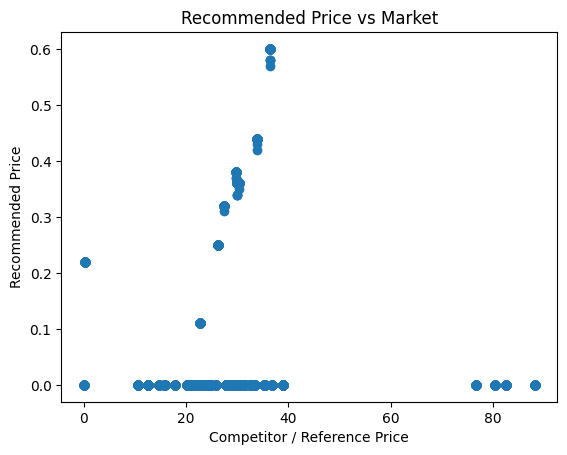

In [39]:
plt.figure()
plt.scatter(
    df["Avg_Competitor_Price"].fillna(df["recommended_price"]),
    df["recommended_price"]
)
plt.xlabel("Competitor / Reference Price")
plt.ylabel("Recommended Price")
plt.title("Recommended Price vs Market")
plt.show()


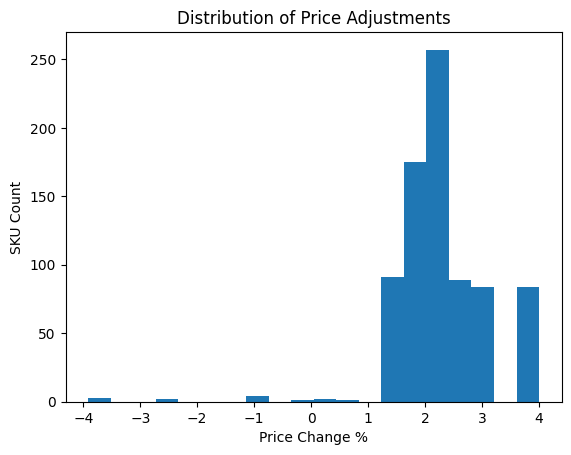

In [40]:
price_change_pct = (
    (df["recommended_price"] - df["target_price"])
    / df["target_price"]
) * 100

plt.figure()
plt.hist(price_change_pct.dropna(), bins=20)
plt.xlabel("Price Change %")
plt.ylabel("SKU Count")
plt.title("Distribution of Price Adjustments")
plt.show()


In [41]:
final_output = df[
    [
        "SKU",
        "landed_cost",
        "target_price",
        "recommended_price"
    ]
]

final_output.to_csv("pricing_recommendations.csv", index=False)

print("✅ Rows written:", final_output.shape[0])


✅ Rows written: 4243
